In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x44_DEFG105015.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.664160,-0.023755,-0.706543,1.833773,1.833773,-0.567883,-0.652099,-0.226954,-0.731263,-0.513210,1.245929,0.409773,-0.278750,-0.070589,-0.149713,-0.425914,-0.797836,-0.269164,1.417837,-0.061924,0.504395,-0.438425,-0.030504,-0.725596,-0.360968,0.925021,-0.127976,-0.220791,-0.755699,-0.017606,3.406680,-0.153198,-0.19396,-0.208143,-0.227652,-0.571267,-0.074895,-0.250822,-0.162479,-0.088361,-0.589398,1.219856,-0.718147,0.0
1,-0.928384,-0.205881,1.267538,0.096737,0.096737,0.610386,-0.863047,-0.637137,-0.819168,-0.393781,0.468999,-0.442798,-0.863295,-0.070589,-0.149713,-0.425914,0.398094,-0.269164,1.417837,1.297452,1.448344,-1.496217,-0.030504,1.378177,-0.360968,-1.081056,-0.127976,-0.220791,1.323278,-0.017606,-0.293541,-0.153198,-0.19396,-0.208143,-0.227652,-0.571267,-0.074895,-0.250822,-0.162479,-0.088361,-0.589398,1.219856,-0.718147,0.0
2,0.931751,0.071267,-0.910159,1.089329,1.089329,1.784386,1.176933,-0.226954,-0.819168,-0.213828,-1.084861,-0.442798,-0.863295,-0.070589,-0.149713,-0.425914,-1.334784,-0.269164,1.417837,2.656828,2.392294,-0.438425,-0.030504,-0.725596,-0.360968,0.925021,-0.127976,-0.220791,-0.755699,-0.017606,-0.293541,-0.153198,-0.19396,-0.208143,-0.227652,-0.571267,-0.074895,3.986890,-0.162479,-0.088361,-0.589398,1.219856,-0.718147,1.0
3,1.608163,0.229638,0.577230,0.096737,0.096737,-0.777068,1.578133,-0.226954,-0.291743,-0.216527,-1.084861,-0.442798,1.250061,-0.070589,-0.149713,3.486114,-0.358515,-0.269164,1.417837,-0.061924,0.504395,-1.496217,-0.030504,-0.725596,-0.360968,0.925021,-0.127976,-0.220791,1.323278,-0.017606,-0.293541,-0.153198,-0.19396,-0.208143,-0.227652,-0.571267,-0.074895,-0.250822,-0.162479,-0.088361,-0.589398,1.219856,-0.718147,1.0
4,-0.917815,-0.166288,0.070674,-0.647707,-0.647707,-0.777068,-0.912962,0.798502,0.851011,0.024086,0.468999,-0.442798,-0.863295,-0.070589,-0.149713,-0.425914,-0.541565,-0.269164,1.417837,-0.061924,0.504395,-0.967321,-0.030504,1.378177,-0.360968,-1.081056,-0.127976,-0.220791,1.323278,-0.017606,-0.293541,-0.153198,-0.19396,-0.208143,-0.227652,-0.571267,-0.074895,-0.250822,-0.162479,-0.088361,-0.589398,1.219856,-0.718147,1.0


In [4]:
data.shape

(3227, 44)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    2470
0.0     757
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(3227, 43)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.76780186 0.75386997 0.76434109 0.76744186 0.76589147]
0.7638692490460076


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  31,  726],
       [  36, 2434]])

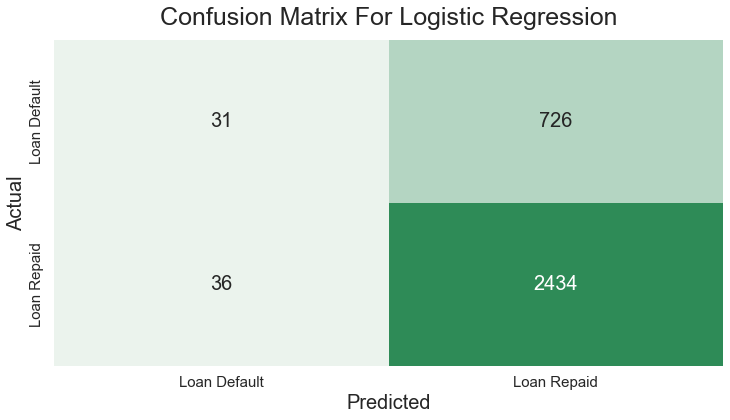

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.7638673690734429

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

2434
726
36
31
0.7638673690734429


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    2470
0.0     757
Name: loan_status_bin, dtype: int64

0.7654167957855593


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 0.1% better than Null Model or "random investment"
TP / (TP+FP)

0.770253164556962

In [17]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [18]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [19]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [20]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.76780186 0.75386997 0.76434109 0.76744186 0.76589147]
0.7638692490460076


In [21]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  31,  726],
       [  36, 2434]])

In [22]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [23]:
y_pred_prob

array([[0.33077904, 0.66922096],
       [0.21631795, 0.78368205],
       [0.50874635, 0.49125365],
       ...,
       [0.24684697, 0.75315303],
       [0.25424584, 0.74575416],
       [0.20951952, 0.79048048]])

In [54]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.83).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [55]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 615,  142],
       [1650,  820]])

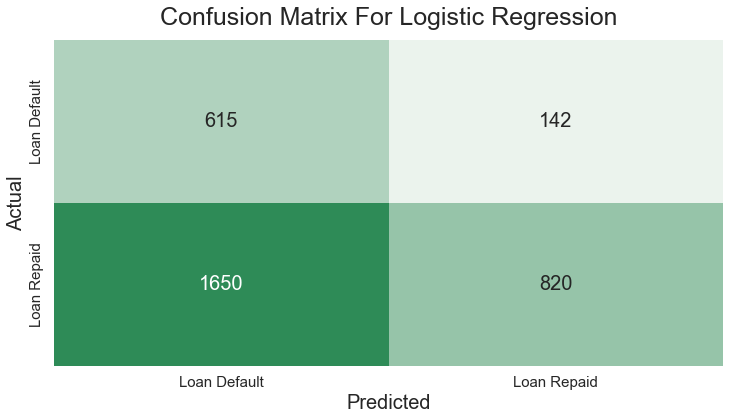

In [56]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [57]:
accuracy_score(y, y_pred_success)

0.44468546637744033

In [58]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

820
142
1650
615
0.44468546637744033


In [59]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8523908523908524

In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 